In [1]:
from sklearn.svm import SVR
import numpy as np
from datetime import datetime
import pandas as pd  
import matplotlib.pyplot as plt 
from pandas import DataFrame 
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv('./data/ACB_2015.csv')
close_colunm_name = 'close'
df = df.set_index(pd.DatetimeIndex(df['date'].values))
df = df[[close_colunm_name]]
time_steps = 10
test_start_idx = int(df.shape[0] * 0.9)
test_start_date = (df.index.values[test_start_idx])
df.shape[0]


1952

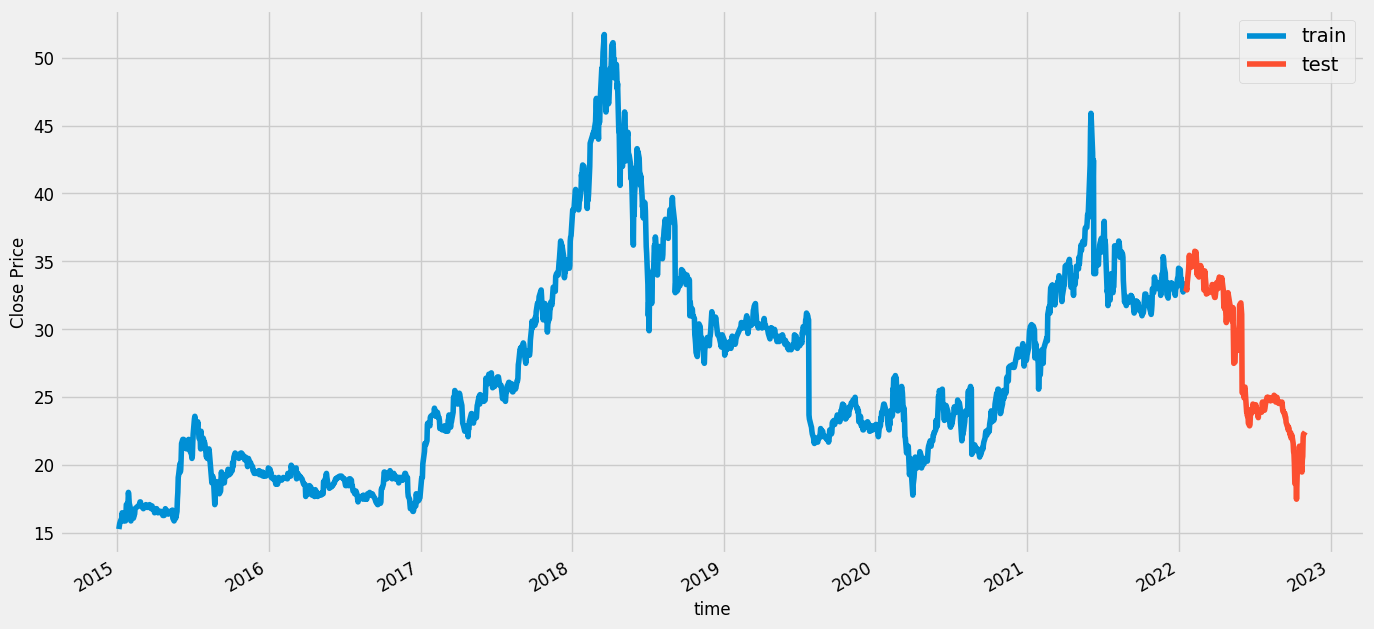

In [3]:
#Visualize the differences
df[df.index < test_start_date][[close_colunm_name]].rename(columns={close_colunm_name: 'train'})\
            .join(df[test_start_date:][[close_colunm_name]].rename(columns={close_colunm_name: 'test'}), how='outer')\
            .plot(y = ['train', 'test'], figsize=(15,8), fontsize=12)
plt.xlabel('time', fontsize=12)
plt.ylabel('Close Price', fontsize=12)
plt.show()

In [4]:
# Create train and test dataset
train = df.copy()[df.index < test_start_date][[close_colunm_name]]
test = df.copy()[test_start_date:][[close_colunm_name]]
print('Training data shape: ', train.shape)
print('Test data shape: ', test.shape)

Training data shape:  (1756, 1)
Test data shape:  (196, 1)


In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train[close_colunm_name] = scaler.fit_transform(train)
test[close_colunm_name] = scaler.fit_transform(test)

In [6]:
#Create data with time_steps
train_data = train.values
test_data = test.values

In [7]:
train_data_timesteps=np.array([[j for j in train_data[i:i+time_steps]] for i in range(0,len(train_data)-time_steps+1)])[:,:,0]
train_data_timesteps.shape

(1747, 10)

In [8]:
test_data_timesteps=np.array([[j for j in test_data[i:i+time_steps]] for i in range(0,len(test_data)-time_steps+1)])[:,:,0]
test_data_timesteps.shape

(187, 10)

In [9]:
x_train, y_train = train_data_timesteps[:,:time_steps-1],train_data_timesteps[:,[time_steps-1]]
x_test, y_test = test_data_timesteps[:,:time_steps-1],test_data_timesteps[:,[time_steps-1]]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(x_test)

(1747, 9) (1747, 1)
(187, 9) (187, 1)
[[ 1.06106097  1.10176517  1.08141307 ...  1.60039166  1.4884551
   1.41722275]
 [ 1.10176517  1.08141307  1.19334963 ...  1.4884551   1.41722275
   1.4477509 ]
 [ 1.08141307  1.19334963  1.37651855 ...  1.41722275  1.4477509
   1.66144797]
 ...
 [-1.35066307 -1.25907861 -1.32013492 ... -1.46259963 -1.41171937
  -1.12678995]
 [-1.25907861 -1.32013492 -1.26925466 ... -1.41171937 -1.12678995
  -1.0759097 ]
 [-1.32013492 -1.26925466 -1.46259963 ... -1.12678995 -1.0759097
  -1.0555576 ]]


In [10]:
#Create and train a SVR model using a linear kernel
linear_SVR = SVR(kernel = 'linear', C = 1000.0)
linear_SVR.fit(x_train, y_train[:,0])

#Create and train a SVR model using a polynomial kernel
polynomial_SVR = SVR(kernel = 'poly', C = 1000.0, degree = 2)
polynomial_SVR.fit(x_train, y_train[:,0])

#Create and train a SVR model using a rbf kernel
rbf_SVR = SVR(kernel = 'rbf', C = 1000.0, gamma = 0.5)
rbf_SVR.fit(x_train, y_train[:,0])

SVR(C=1000.0, gamma=0.5)

In [11]:
#Make models predicttions
y_train_linear_SVR_prediction = linear_SVR.predict(x_train).reshape(-1,1)
y_test_linear_SVR_prediction = linear_SVR.predict(x_test).reshape(-1,1)

y_train_polynomial_SVR_prediction = polynomial_SVR.predict(x_train).reshape(-1,1)
y_test_polynomial_SVR_prediction = polynomial_SVR.predict(x_test).reshape(-1,1)

y_train_rbf_SVR_prediction = rbf_SVR.predict(x_train).reshape(-1,1)
y_test_rbf_SVR_prediction = rbf_SVR.predict(x_test).reshape(-1,1)

In [12]:
#Scaling the predictions
y_train_linear_SVR_prediction = scaler.inverse_transform(y_train_linear_SVR_prediction)
y_test_linear_SVR_prediction = scaler.inverse_transform(y_test_linear_SVR_prediction)

y_train_polynomial_SVR_prediction = scaler.inverse_transform(y_train_polynomial_SVR_prediction)
y_test_polynomial_SVR_prediction = scaler.inverse_transform(y_test_polynomial_SVR_prediction)

y_train_rbf_SVR_prediction = scaler.inverse_transform(y_train_rbf_SVR_prediction)
y_test_rbf_SVR_prediction = scaler.inverse_transform(y_test_rbf_SVR_prediction)

In [13]:
# Scaling the original values
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)
print(y_train)

[[20.58410856]
 [20.71476765]
 [20.64943811]
 ...
 [31.98411407]
 [31.78812543]
 [31.5921368 ]]


In [14]:
# Check model performance on training and testing data
train_timestamps = df[df.index < test_start_date].index[time_steps-1:]
test_timestamps = df[test_start_date:].index[time_steps-1:]

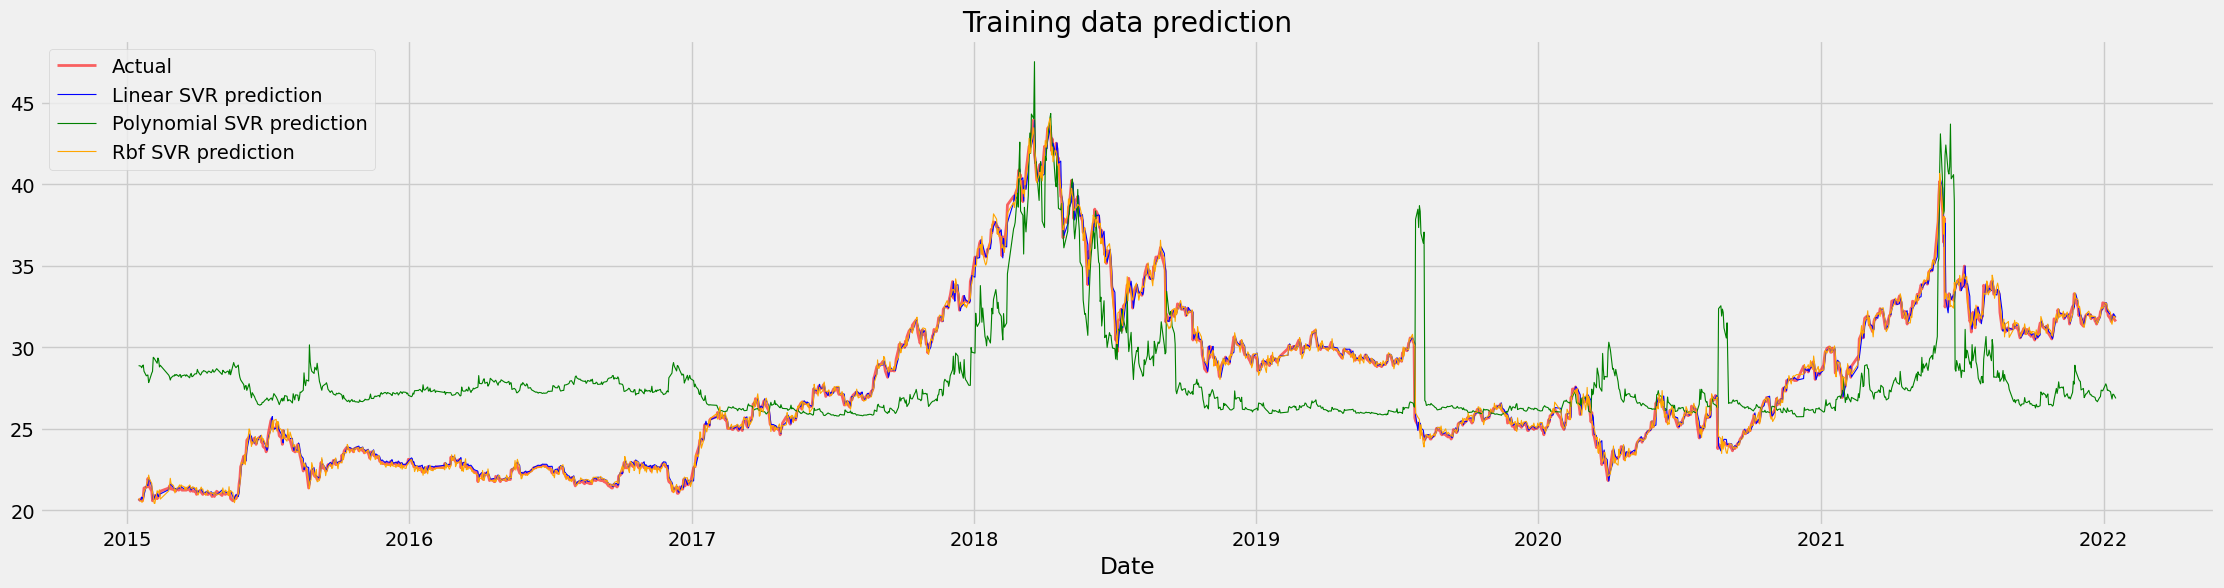

In [15]:
#plot the predictions for training data
plt.figure(figsize=(25,6))
plt.plot(train_timestamps, y_train, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(train_timestamps, y_train_linear_SVR_prediction, color = 'blue', linewidth=0.8)
plt.plot(train_timestamps, y_train_polynomial_SVR_prediction, color = 'green', linewidth=0.8)
plt.plot(train_timestamps, y_train_rbf_SVR_prediction, color = 'orange', linewidth=0.8)
plt.legend(['Actual','Linear SVR prediction','Polynomial SVR prediction','Rbf SVR prediction'])
plt.xlabel('Date')
plt.title("Training data prediction")
plt.show()

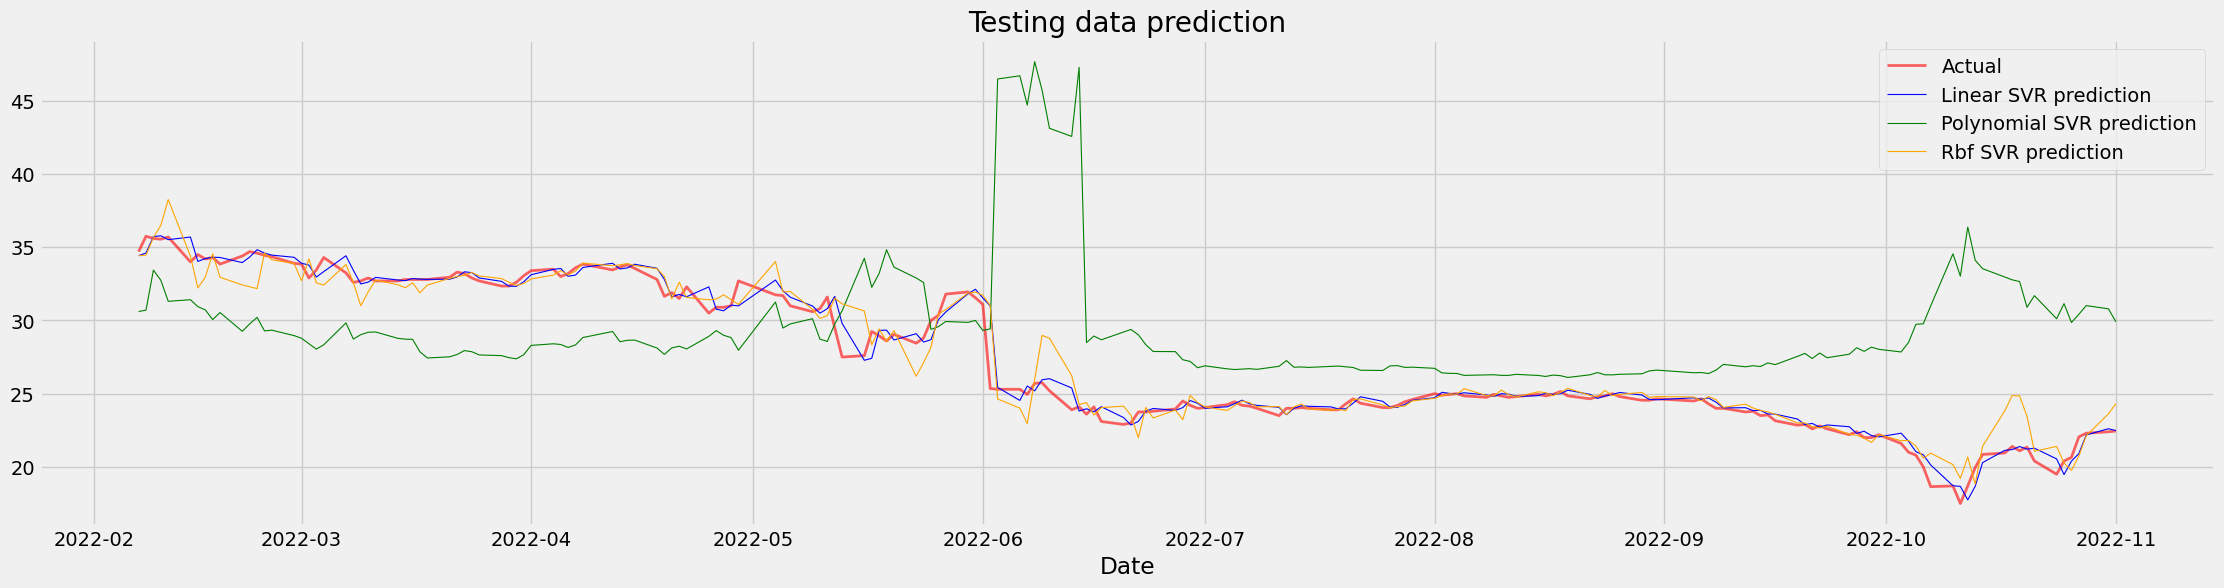

In [16]:
#plot the predictions for testing data
plt.figure(figsize=(25,6))
plt.plot(test_timestamps, y_test, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(test_timestamps, y_test_linear_SVR_prediction, color = 'blue', linewidth=0.8)
plt.plot(test_timestamps, y_test_polynomial_SVR_prediction, color = 'green', linewidth=0.8)
plt.plot(test_timestamps, y_test_rbf_SVR_prediction, color = 'orange', linewidth=0.8)
plt.legend(['Actual','Linear SVR prediction','Polynomial SVR prediction','Rbf SVR prediction'])
plt.xlabel('Date')
plt.title("Testing data prediction")
plt.show()

In [17]:
from sklearn.metrics import mean_squared_error
print("MSE for linear SVR on testing data:",mean_squared_error(y_test,y_test_linear_SVR_prediction))
print("MSE for polinomial SVR on testing data:",mean_squared_error(y_test,y_test_polynomial_SVR_prediction))
print("MSE for RBF SVR on testing data:",mean_squared_error(y_test,y_test_rbf_SVR_prediction))

MSE for linear SVR on testing data: 0.5134506705219849
MSE for polinomial SVR on testing data: 45.01513052011536
MSE for RBF SVR on testing data: 1.3567781303887823


In [18]:
from sklearn.metrics import mean_absolute_percentage_error
print("MAPE for linear SVR on testing data:",mean_absolute_percentage_error(y_test,y_test_linear_SVR_prediction))
print("MAPE for polinomial SVR on testing data:",mean_absolute_percentage_error(y_test,y_test_polynomial_SVR_prediction))
print("MAPE for RBF SVR on testing data:",mean_absolute_percentage_error(y_test,y_test_rbf_SVR_prediction))

MAPE for linear SVR on testing data: 0.016483709483865613
MAPE for polinomial SVR on testing data: 0.20142278714488004
MAPE for RBF SVR on testing data: 0.028527445304929688


In [19]:
from sklearn.metrics import mean_absolute_error
print("MAE for linear SVR on testing data:",mean_absolute_error(y_test,y_test_linear_SVR_prediction))
print("MAE for polinomial SVR on testing data:",mean_absolute_error(y_test,y_test_polynomial_SVR_prediction))
print("MAE for RBF SVR on testing data:",mean_absolute_error(y_test,y_test_rbf_SVR_prediction))

MAE for linear SVR on testing data: 0.4346911703092807
MAE for polinomial SVR on testing data: 5.046822130539235
MAE for RBF SVR on testing data: 0.7461733420118098
